Proof of scoring using x,y coordinate of dart tip

In [16]:
import cv2
import matplotlib.pyplot as plt
import os

cur_dir = os.getcwd()
parent_dir = os.path.dirname(cur_dir)
print(cur_dir)
print(parent_dir)

/Users/zach/Desktop/SDP/SmokingDartsv2/core
/Users/zach/Desktop/SDP/SmokingDartsv2


Capture images from webcam

In [31]:
# Capture images of board with no darts

test_image_path = os.path.dirname(os.getcwd()) + "/images/test"
print(test_image_path)

def capture_image(camera, image_name):
    ret, img = camera.read() # Read an image from camera
    image_name = image_name + ".jpeg"
    cv2.imwrite(os.path.join(test_image_path, image_name), img)
    camera.release()
    print(image_name + " captured!")

camX = cv2.VideoCapture(1) # First camera connected to USB port 0
camY = cv2.VideoCapture(2) # Second camera connected to USB port 1

# Capture images of dartboard with no dart
capture_image(camX, "image_nodartX")

capture_image(camY, "image_nodartY")

/Users/zach/Desktop/SDP/SmokingDartsv2/images/test


In [32]:
# Capture images of board with darts

test_image_path = os.path.dirname(os.getcwd()) + "/images/test"
print(test_image_path)

def capture_image(camera, image_name):
    ret, img = camera.read() # Read an image from camera
    image_name = image_name + ".jpeg"
    cv2.imwrite(os.path.join(test_image_path, image_name), img)
    camera.release()
    print(image_name + " captured!")

camX = cv2.VideoCapture(1) # First camera connected to USB port 0
camY = cv2.VideoCapture(2) # Second camera connected to USB port 1

# Capture images of dartboard with darts
capture_image(camX, "image_dartX")
capture_image(camY, "image_dartY")

image_dartX.jpeg captured!
image_dartY.jpeg captured!


Load images from dataset

In [33]:
# # load dataset 1 (bullseye)
# image_nodart = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'nodart_1.jpeg'))
# image_dartX = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'dart_1_2.jpeg'))
# image_dartY = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'dart_1_2.jpeg'))


# # load dataset 2 (dart in large beige space by 16 (in between 8 & 7))
# image_nodart = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'nodart_2.jpeg'))
# image_dartX = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'dartx_2_1.jpeg'))
# image_dartY = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'darty_2_1.jpeg'))


# # load dataset 3 (Black 3 in between 17 & 19)
# image_nodart = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'nodart_3.jpeg'))
# image_dartX = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'dartx_3_1.jpeg'))
# image_dartY = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'darty_3.jpeg'))


# load recently captured images
image_nodartX = cv2.imread(os.path.join(parent_dir, 'images/test/', 'image_nodartX.jpeg'))
image_nodartY = cv2.imread(os.path.join(parent_dir, 'images/test/', 'image_nodartY.jpeg'))
image_dartX = cv2.imread(os.path.join(parent_dir, 'images/test/', 'image_dartX.jpeg'))
image_dartY = cv2.imread(os.path.join(parent_dir, 'images/test/', 'image_dartY.jpeg'))


Display Images

Image of nodartX


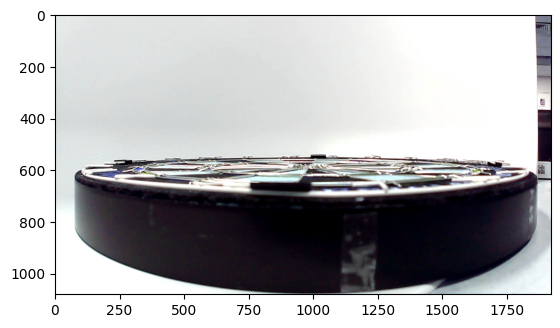

Image of nodartY


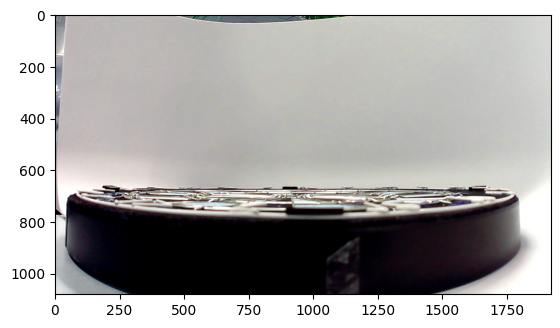

Image Resolution: 1920 x 1080


In [34]:
# display images of no darts
print("Image of nodartX")
plt.imshow(image_nodartX)
plt.show()

print("Image of nodartY")
plt.imshow(image_nodartY)
plt.show()

image_height, image_width, channels = image_nodartX.shape
print('Image Resolution: {} x {}'.format(image_width, image_height))

Image of dartx


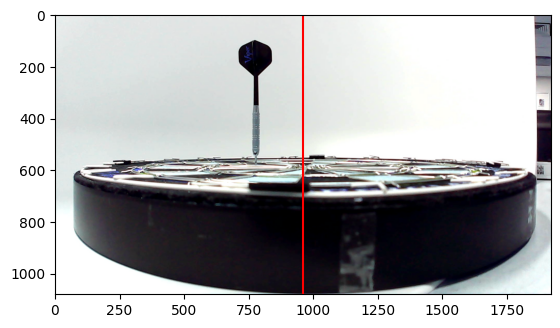

Image of darty


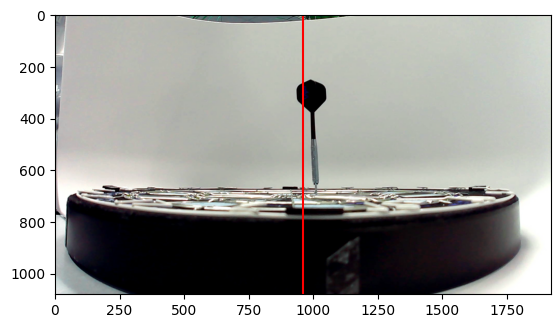

In [35]:
# display images of darts

print("Image of dartx")
plt.plot([image_dartX.shape[1]//2, image_dartX.shape[1]//2], [0, image_dartX.shape[0]], 'r-')
plt.imshow(image_dartX)
plt.show()

print("Image of darty")
plt.plot([image_dartY.shape[1]//2, image_dartY.shape[1]//2], [0, image_dartY.shape[0]], 'r-')
plt.imshow(image_dartY)
plt.show()

Create difference image to determine dart tip coordinates

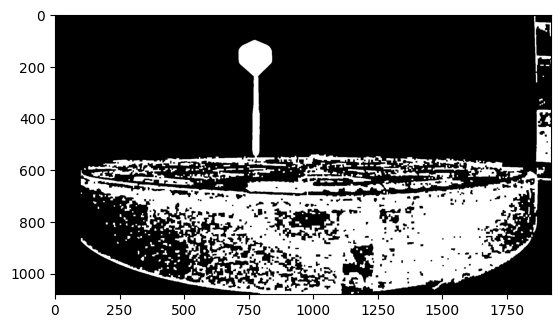

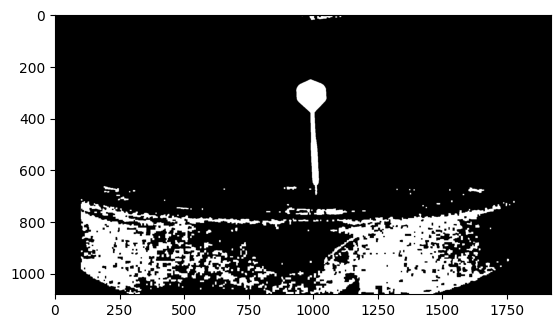

coordinates:  [935.1373478539398, 1272.8129615674454]


In [36]:
from dart_tip_coordinate import *

def show_diff_image(dart, nodart):
    # dartboard
    db = DartboardImage("x", dart, last_img=nodart)
    diff = db.get_diff_to_last_img()

    # set left most 100 pixels to 0
    diff[:, :100] = 0

    # set 1400 to image_height to 0
    diff[1415:, :] = 0

    # opencv dilation
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.dilate(diff.astype('uint8'),kernel,iterations = 1)

    # opencv erosion 
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.erode(diff.astype('uint8'),kernel,iterations = 1)

    # get the tip
    isolated_dart_tip = isolate_dart_tip(diff)
    y_coordinate, x_coordinate = center_of_mass(isolated_dart_tip)

    # show image diff
    plt.imshow(diff, cmap='gray')
    plt.show()
    return x_coordinate


x = show_diff_image(image_dartX, image_nodartX)
y = show_diff_image(image_dartY, image_nodartY)
darttip_pixel_coordinates = [x, y]
print("coordinates: ", darttip_pixel_coordinates)

Determine Angle of Camera to Dart

In [ ]:
# compute the angles from the camera to the dart using pixel width of board and camera field of view
def angle_from_camera_to_dart(coordinates, board_width, fov=110):
    angle = [0, 0]
    angle[0] = coordinates[0] / board_width * fov
    angle[1] = coordinates[1] / board_width * fov
    return angle

# get image dimensions
fov = 110
angles_cameras_to_darts = angle_from_camera_to_dart(darttip_pixel_coordinates, image_width)
print("coordinates:", darttip_pixel_coordinates)
print("dart_angles:", angles_cameras_to_darts)

coordinates: [2124.9156626506024, 2306.6921241050118]
dart_angles: [35.30985848154523, 38.33044948289578]


Calculate Angle of Dart to Scoring Area

In [ ]:
import math

cam_dist = 440 #mm
x1, y1 = -251.4, -251.4 ## mm
x2, y2 = 251,4, -251.4
board_radius = 228.6 #mm

#calculate angle relative to horizontal and vertical plane
mod_angA, mod_angB = (fov/2 - angles_cameras_to_darts[1]) , (fov/2 - angles_cameras_to_darts[0]) + 90

# convert to radians from degrees
angA, angB  = mod_angA * math.pi/180, mod_angB * math.pi/180

slopeA = math.tan(angA)
slopeB = math.tan(angB)

#### use slope-intercept form to calculate x_dart and y_dart
x_dart = (x1*slopeA - y1 -x2*slopeB + y2 )/(slopeA - slopeB)
y_dart = (x_dart - x1) * slopeA
print("x coordinate: " + str(x_dart))
print("y coordinate: " + str(y_dart))

x coordinate: 12.463695132736305
y coordinate: -37.56054293321805


Create Visualiation of Dart Board

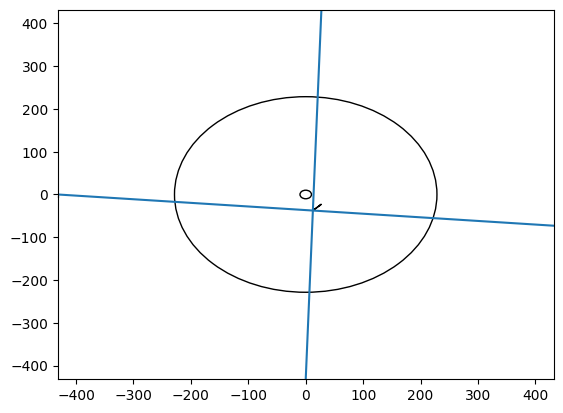

In [ ]:

### for simulation and visualization
fig, ax = plt.subplots() 

ax.set_xlim(-cam_dist, cam_dist)
ax.set_ylim(-cam_dist, cam_dist)

dart_board = plt.Circle((0, 0), board_radius, edgecolor='black', fill=False)
#dart_board = ax.pie([.05]*20)
dart = plt.Arrow(x_dart, y_dart, 15, 15, color='black')
bullseye = plt.Circle((0, 0), 10, edgecolor='black', fill=False)

camA = plt.Rectangle((-cam_dist, -5), 1, 1, edgecolor='black', fill=False, clip_on=False)
camB = plt.Rectangle((-5, -cam_dist), 1, 1, edgecolor='black', fill=False, clip_on=False) 

ax.add_patch(dart_board)
ax.add_patch(dart)
ax.add_patch(bullseye)
ax.add_patch(camA)
ax.add_patch(camB)


leg_Cam1_Dart = ax.axline((-cam_dist, 0), slope=slopeA)
leg_Cam2_Dart = ax.axline((0, -cam_dist), slope = slopeB)

ax.plot(x_dart, y_dart)

Determine Score of Hit

In [ ]:
#find the radius
radius = math.sqrt((x_dart**2)+(y_dart**2))

# solve for the angle
theta = math.atan(y_dart/x_dart)          # in radians
angle = theta * (180/3.1415)    # convert to degrees

## What if angle is in Q3 or Q4 ##
# makes sure that the arctan angle is accurate for scoring
if x_dart < 0:
    angle = 180 + angle

print("angle: " + str(angle))

slice_map = [6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10]
slice_key = int(((angle + 9)%360)//18)
slice_area = slice_map[slice_key]

print("score area: " + str(slice_area))
print("Radius: " + str(radius))
# use multiplyer.py to figure out the multiplyer

score = 0
if radius <= 5:
    score = 50
    print("Bullseye!!!")
elif radius > 5 and radius <= 15:
    score = 25
    print("Bull!!!")
elif radius >= 95 and radius <= 105:
    score = 3*slice_area
    print("Triple Score!!!")
    
elif radius >= 160 and radius <=170:
    score = 2*slice_area
    print("Double Score!!!")
    
elif radius > 170:
    score = 0
    print("Missed. Try Again.")
else:
    score = slice_area
    print("Nice hit!!!")
    
print("score is: " + str(score))

angle: -71.64474753090506
score area: 17
Radius: 39.574462495401136
Nice hit!!!
score is: 17
